In [37]:

import sys
sys.path.insert(1,"/home1/07064/tg863631/anaconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages") #work around for h5py
from cbrain.imports import *
from cbrain.cam_constants import *
from cbrain.utils import *
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
from tensorflow import math as tfm
# import tensorflow_probability as tfp
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin
# import cartopy.crs as ccrs
import matplotlib.ticker as mticker
# from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pickle
from climate_invariant import *
from tensorflow.keras import layers
import datetime


## DataGenerators

In [38]:
TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'
path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)


In [39]:
scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

In [40]:

class DataGeneratorCRH(DataGenerator):
    
    def __init__(self, data_fn, input_vars, output_vars,
             norm_fn=None, input_transform=None, output_transform=None,
             batch_size=1024, shuffle=True, xarray=False, var_cut_off=None, normalize_flag=True):
        
        self.norm_crh = {'mean': 0.6504839858099173,
         'std': 0.16682537869066533,
         'min': 0.17238214193105322,
         'max': 1.1338450824626287}
        super().__init__(data_fn, input_vars,output_vars,norm_fn,input_transform,output_transform,
                        batch_size,shuffle,xarray,var_cut_off,normalize_flag)
        
        
        
    def __getitem__(self, index):
        # Compute start and end indices for batch
        start_idx = index * self.batch_size
        end_idx = start_idx + self.batch_size

        # Grab batch from data
        batch = self.data_ds['vars'][start_idx:end_idx]

        # Split into inputs and outputs
        X = batch[:, self.input_idxs]
        Y = batch[:, self.output_idxs]
        X_CRH = np.array(CRH_scale(X)).reshape(-1,1)
        # Normalize
        X = self.input_transform.transform(X)
        Y = self.output_transform.transform(Y)
        X = np.hstack((X,X_CRH))
        return np.array(X), Y

### Positvive CRH (>=0.8)

In [41]:
TRAINFILE = 'PosCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'PosCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'PosCRH_CI_SP_M4K_valid.nc'

In [42]:
train_gen_posCRH_DG = DataGeneratorCRH(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

In [43]:
valid_gen_posCRH_DG = DataGeneratorCRH(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

In [44]:
train_gen_posCRH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

In [45]:
valid_gen_posCRH = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Negative CRH (<0.8)

In [46]:
TRAINFILE = 'NegCRH_CI_SP_M4K_train_shuffle.nc'
NORMFILE = 'NegCRH_CI_SP_M4K_NORM_norm.nc'
VALIDFILE = 'NegCRH_CI_SP_M4K_valid.nc'

In [47]:
train_gen_negCRH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

In [48]:
valid_gen_negCRH = DataGenerator(
    data_fn = TRAINDIR+VALIDFILE,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Generators using RH input¶

In [49]:
scale_dict_RH = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
scale_dict_RH['RH'] = 0.01*L_S/G, # Arbitrary 0.1 factor as specific humidity is generally below 2%

in_vars_RH = ['RH','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars_RH = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

### For positive CRH

In [50]:
TRAINFILE_RH = 'PosCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'PosCRH_CI_RH_M4K_NORM_norm.nc'

In [51]:
train_gen_RH_posCRH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### For negative CRH

In [52]:
TRAINFILE_RH = 'NegCRH_CI_RH_M4K_NORM_train_shuffle.nc'
NORMFILE_RH = 'NegCRH_CI_RH_M4K_NORM_norm.nc'

In [53]:
train_gen_RH_negCRH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_RH,
    input_vars = in_vars_RH,
    output_vars = out_vars_RH,
    norm_fn = TRAINDIR+NORMFILE_RH,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict_RH,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### Generators using T-TNS input

In [54]:
in_vars = ['QBP','TfromNS','PS', 'SOLIN', 'SHFLX', 'LHFLX']
out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']

### For positive CRH

In [55]:
TRAINFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'PosCRH_CI_TNS_M4K_NORM_norm.nc'

In [56]:
train_gen_TNS_posCRH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

### For negative CRH

In [57]:
TRAINFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_train_shuffle.nc'
NORMFILE_TNS = 'NegCRH_CI_TNS_M4K_NORM_norm.nc'

In [58]:
train_gen_TNS_negCRH = DataGenerator(
    data_fn = TRAINDIR+TRAINFILE_TNS,
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = TRAINDIR+NORMFILE_TNS,
    input_transform = ('mean', 'maxrs'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True,
    normalize_flag=True
)

## Building the Model

In [59]:
class ScaleOp(layers.Layer):
    #if index = -1 that means take shflx+lhflx
    def __init__(self,index,inp_subQ, inp_divQ,**kwargs):
        self.scaling_index = index
        self.inp_subQ, self.inp_divQ =  np.array(inp_subQ), np.array(inp_divQ)
        super(ScaleOp,self).__init__(**kwargs)
        
        
    def get_config(self):
        config = {'index':self.scaling_index,'inp_subQ': list(self.inp_subQ), 'inp_divQ': list(self.inp_divQ)}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    
    def call(self,inps):      
        inp,op = inps
        #for scaling using LHFLX+SHFLX
        if self.scaling_index==-1:
            scaling_factor = (inp[:,62]*self.inp_divQ[62] + self.inp_subQ[62]) + (inp[:,63]*self.inp_divQ[63] + self.inp_subQ[63])
        elif self.scaling_index==0:
            scaling_factor = inp[:,64]
        else:
            scaling_factor = inp[:,self.scaling_index]*self.inp_divQ[self.scaling_index] + self.inp_subQ[self.scaling_index]
        
        op_updated = op[:,:60] * tf.expand_dims(scaling_factor,1)
        op_rest = op[:,60:]
        op = tf.concat((op_updated,op_rest),axis=1)
        return op



### For Positive CRH

In [24]:
inp = Input(shape=(65,))

inpRH = QV2RH(inp_subQ=train_gen_posCRH.input_transform.sub, 
              inp_divQ=train_gen_posCRH.input_transform.div, 
              inp_subRH=train_gen_RH_posCRH.input_transform.sub, 
              inp_divRH=train_gen_RH_posCRH.input_transform.div, 
              hyam=hyam, hybm=hybm)(inp[:,:64])

inpTNS = T2TmTNS(inp_subT=train_gen_posCRH.input_transform.sub, 
              inp_divT=train_gen_posCRH.input_transform.div, 
              inp_subTNS=train_gen_TNS_posCRH.input_transform.sub, 
              inp_divTNS=train_gen_TNS_posCRH.input_transform.div, 
              hyam=hyam, hybm=hybm)(inpRH)

densout = Dense(128, activation='linear')(inpTNS)
densout = LeakyReLU(alpha=0.3)(densout)
for i in range (6):
    densout = Dense(128, activation='linear')(densout)
    densout = LeakyReLU(alpha=0.3)(densout)
out = Dense(64, activation='linear')(densout)
out = ScaleOp(0,
              inp_subQ=train_gen_posCRH.input_transform.sub, 
              inp_divQ=train_gen_posCRH.input_transform.div,
              )([inp,out])
model_posCRH = tf.keras.models.Model(inp, out)

In [50]:
model_posCRH.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 65)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, 64)]         0           input_1[0][0]                    
__________________________________________________________________________________________________
q_v2rh (QV2RH)                  (None, 64)           0           tf_op_layer_strided_slice[0][0]  
__________________________________________________________________________________________________
t2_tm_tns (T2TmTNS)             (None, 64)           0           q_v2rh[0][0]                     
______________________________________________________________________________________________

In [51]:
model_posCRH.compile(tf.keras.optimizers.Adam(), loss=mse)

In [52]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/CRHNet/'
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
mcp_save_posScaledCRH = ModelCheckpoint(path_HDF5+'Pos_CRH_Scaled_CRHNet.hdf5',save_best_only=True, monitor='val_loss', mode='min')
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0, update_freq=1000,embeddings_freq=1)

In [ ]:
Nep = 25
model_posCRH.load_weights(path_HDF5+'Pos_CRH_Scaled_CRHNet.hdf5')
model_posCRH.fit_generator(train_gen_posCRH_DG, epochs=Nep, validation_data=valid_gen_posCRH_DG,\
              callbacks=[earlyStopping, mcp_save_posScaledCRH])

Epoch 1/25
9144/9144 [==============================] - 1448s 158ms/step - loss: 515.5708 - val_loss: 493.2137
Epoch 2/25
9144/9144 [==============================] - 823s 90ms/step - loss: 512.0408 - val_loss: 494.3370
Epoch 3/25
9144/9144 [==============================] - 819s 90ms/step - loss: 509.4784 - val_loss: 491.1243
Epoch 4/25
9144/9144 [==============================] - 1463s 160ms/step - loss: 507.5116 - val_loss: 487.6801
Epoch 5/25
9144/9144 [==============================] - 816s 89ms/step - loss: 505.7620 - val_loss: 485.5296
Epoch 6/25
9144/9144 [==============================] - 822s 90ms/step - loss: 504.2029 - val_loss: 484.8606
Epoch 7/25
9144/9144 [==============================] - 819s 90ms/step - loss: 502.8993 - val_loss: 485.3126
Epoch 8/25
9144/9144 [==============================] - 823s 90ms/step - loss: 501.9858 - val_loss: 485.7741
Epoch 9/25
9144/9144 [==============================] - 825s 90ms/step - loss: 501.1030 - val_loss: 486.9780
Epoch 10/25
914

## Model Diagnostics

In [60]:
import yaml

In [61]:
##Calculate mean and range from the norm trained file
from os import path
dir_ = '/oasis/scratch/comet/ankitesh/temp_project/PrepData'
in_fn = 'CI_SP_M4K_NORM_train.nc'
norm_fn = 'CI_SP_M4K_NORM_norm.nc'
in_fn = path.join(dir_, in_fn)
norm_fn = path.join(dir_, norm_fn)
data_ds = xr.open_dataset(in_fn)
norm_ds = xr.Dataset()
in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']

path = '/home/ankitesh/CBrain_project/CBRAIN-CAM/cbrain/'
path_hyam = 'hyam_hybm.pkl'

hf = open(path+path_hyam,'rb')
hyam,hybm = pickle.load(hf)


In [62]:
## functions different from climate_invariant file
class CrhClass:
    def __init__(self):
        pass
    
    def eliq(self,T):
        a_liq = np.array([-0.976195544e-15,-0.952447341e-13,0.640689451e-10,0.206739458e-7,0.302950461e-5,0.264847430e-3,0.142986287e-1,0.443987641,6.11239921]);
        c_liq = -80
        T0 = 273.16
        return 100*np.polyval(a_liq,np.maximum(c_liq,T-T0))

    def eice(self,T):
        a_ice = np.array([0.252751365e-14,0.146898966e-11,0.385852041e-9,0.602588177e-7,0.615021634e-5,0.420895665e-3,0.188439774e-1,0.503160820,6.11147274]);
        c_ice = np.array([273.15,185,-100,0.00763685,0.000151069,7.48215e-07])
        T0 = 273.16
        return (T>c_ice[0])*self.eliq(T)+\
    (T<=c_ice[0])*(T>c_ice[1])*100*np.polyval(a_ice,T-T0)+\
    (T<=c_ice[1])*100*(c_ice[3]+np.maximum(c_ice[2],T-T0)*(c_ice[4]+np.maximum(c_ice[2],T-T0)*c_ice[5]))    

    def esat(self,T):
        T0 = 273.16
        T00 = 253.16
        omega = np.maximum(0,np.minimum(1,(T-T00)/(T0-T00)))

        return (T>T0)*self.eliq(T)+(T<T00)*self.eice(T)+(T<=T0)*(T>=T00)*(omega*self.eliq(T)+(1-omega)*self.eice(T))

    def RH(self,T,qv,P0,PS,hyam,hybm):
        R = 287
        Rv = 461
        S = PS.shape
        p = 1e5 * np.tile(hyam,(S[0],1))+np.transpose(np.tile(PS,(30,1)))*np.tile(hybm,(S[0],1))

        return Rv*p*qv/(R*self.esat(T))

    def qv(self,T,RH,P0,PS,hyam,hybm):
        R = 287
        Rv = 461
        S = PS.shape
        p = 1e5 * np.tile(hyam,(S[0],1))+np.transpose(np.tile(PS,(30,1)))*np.tile(hybm,(S[0],1))

        return R*self.esat(T)*RH/(Rv*p)


    def qsat(self,T,P0,PS,hyam,hybm):
        return self.qv(T,1,P0,PS,hyam,hybm)



    def dP(self,PS):    
        S = PS.shape
        P = 1e5 * np.tile(hyai,(S[0],1))+np.transpose(np.tile(PS,(31,1)))*np.tile(hybi,(S[0],1))
        return P[:, 1:]-P[:, :-1]

    
## try with np.sum(qv0*dP0/G,axis=1)

def CRH(inp):
    crh_class = CrhClass()
    qv0 = inp[:,:30]
    T = inp[:,30:60]
    ps = inp[:,60]

    dP0 = crh_class.dP(ps)
    qsat0 = crh_class.qsat(T,P0,ps,hyam,hybm)
    
    return np.sum(qv0*dP0,axis=1)/np.sum(qsat0*dP0,axis=1)

def CRH_scale(inp):
    crh_class = CrhClass()
    qv0 = inp[:,:30]
    T = inp[:,30:60]
    ps = inp[:,60]

    dP0 = crh_class.dP(ps)
    qsat0 = crh_class.qsat(T,P0,ps,hyam,hybm)
    return np.sum(qv0*dP0/G,axis=1)

In [63]:
class CRHNet:
    def __init__(self,pos_model,neg_model,dict_lay,subQ,divQ,pos_subQ,pos_divQ,neg_subQ,neg_divQ,scaling=False):
        self.pos_model = load_model(pos_model,custom_objects=dict_lay)
        self.neg_model = load_model(neg_model,custom_objects=dict_lay)
        self.subQ,self.divQ = np.array(subQ),np.array(divQ)
        self.pos_subQ,self.pos_divQ = np.array(pos_subQ),np.array(pos_divQ)
        self.neg_subQ,self.neg_divQ = np.array(neg_subQ),np.array(neg_divQ)
        self.scaling = scaling
        
        
    
    def reorder(self,op_pos,op_neg,mask):
        op = []
        pos_i=0
        neg_i = 0
        for m in mask:
            if m:
                op.append(op_pos[pos_i])
                pos_i += 1
            else:
                op.append(op_neg[neg_i])
                neg_i += 1
        return np.array(op)
                
                
    def predict_on_batch(self,inp):
        
        inp_de = inp*self.divQ + self.subQ
        mask = CRH(inp_de) >= 0.8
        pos_inp = inp[mask]
        ## append for pw 
        if self.scaling:
            scaled = CRH_scale(inp_de[mask])
        ####
        
        neg_inp = inp[np.logical_not(mask)]
        ##denormalize and normalize pos_inp
        pos_inp = pos_inp*self.divQ + self.subQ
        pos_inp = (pos_inp - self.pos_subQ) / self.pos_divQ
        ##denormalize and normalize neg_inp
        neg_inp = neg_inp*self.divQ + self.subQ
        neg_inp = (neg_inp - self.neg_subQ) / self.neg_divQ
        op_neg = self.neg_model.predict_on_batch(neg_inp)
        if self.scaling:
            pos_inp = np.hstack((pos_inp,scaled.reshape(-1,1)))

        op_pos = self.pos_model.predict_on_batch(pos_inp)
        op = self.reorder(np.array(op_pos),np.array(op_neg),mask)
        return op
    
    def get_crh_values(self,inp):
        inp_de = inp*self.divQ + self.subQ
        return CRH(inp_de)
    
    def predict_on_batch_seperate(self,inp):
        inp_de = inp*self.divQ + self.subQ

        mask = CRH(inp_de) >= 0.8
        pos_inp = inp[mask]
        ## append for pw 
        if self.scaling:
            scaled = CRH_scale(pos_inp)
        
        ####
        
        neg_inp = inp[np.logical_not(mask)]
        ##denormalize and normalize pos_inp
        pos_inp = pos_inp*self.divQ + self.subQ
        pos_inp = (pos_inp - self.pos_subQ) / self.pos_divQ

        ##denormalize and normalize neg_inp
        neg_inp = neg_inp*self.divQ + self.subQ
        neg_inp = (neg_inp - self.neg_subQ) / self.neg_divQ
        op_neg = self.neg_model.predict_on_batch(neg_inp)
        ####append for pw
        if self.scaling:
            pos_inp = np.hstack((pos_inp,scaled.reshape(-1,1)))
        ###
        op_pos = self.pos_model.predict_on_batch(pos_inp)
        return mask,op_pos,op_neg
        




In [64]:
def get_norm():
    
    TRAINDIR = '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData/'

    scale_dict = load_pickle('/home/ankitesh/CBrain_project/CBRAIN-CAM/nn_config/scale_dicts/009_Wm2_scaling.pkl')
    in_vars = ['QBP','TBP','PS', 'SOLIN', 'SHFLX', 'LHFLX']
    out_vars = ['PHQ','TPHYSTND','FSNT', 'FSNS', 'FLNT', 'FLNS']
    TRAINFILE = 'PosCRH_CI_SP_M4K_train_shuffle.nc'
    NORMFILE = 'PosCRH_CI_SP_M4K_NORM_norm.nc'

    train_gen_posCRH = DataGenerator(
        data_fn = TRAINDIR+TRAINFILE,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = TRAINDIR+NORMFILE,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        batch_size=1024,
        shuffle=True,
        normalize_flag=True
    )

    TRAINFILE = 'NegCRH_CI_SP_M4K_train_shuffle.nc'
    NORMFILE = 'NegCRH_CI_SP_M4K_NORM_norm.nc'

    train_gen_negCRH = DataGenerator(
        data_fn = TRAINDIR+TRAINFILE,
        input_vars = in_vars,
        output_vars = out_vars,
        norm_fn = TRAINDIR+NORMFILE,
        input_transform = ('mean', 'maxrs'),
        output_transform = scale_dict,
        batch_size=1024,
        shuffle=True,
        normalize_flag=True
    )
    
    return train_gen_posCRH,train_gen_negCRH

In [65]:
def load_combined_model(path_pos,path_neg,dict_lay,config_fn, data_fn,nlat=64, nlon=128, nlev=30, ntime=48,scaling=False):
    with open(config_fn, 'r') as f:
        config = yaml.load(f)
    out_scale_dict = load_pickle(config['output_dict'])
    ngeo = nlat * nlon
    train_gen = DataGenerator(
            data_fn = data_fn,
            input_vars=config['inputs'],
            output_vars=config['outputs'],
            norm_fn=config['data_dir'] + config['norm_fn'],
            input_transform=(config['input_sub'], config['input_div']),
            output_transform=out_scale_dict,
            batch_size=ngeo,
            shuffle=False,
            xarray=True,
            normalize_flag=True,
            var_cut_off=config['var_cut_off'] if 'var_cut_off' in config.keys() else None
        )
    train_gen_posCrh,train_gen_negCRH = get_norm()
    
    crh_obj = CRHNet(path_pos,path_neg,dict_lay,train_gen.input_transform.sub,train_gen.input_transform.div,
                      train_gen_posCrh.input_transform.sub, train_gen_posCrh.input_transform.div,
                  train_gen_negCRH.input_transform.sub,train_gen_negCRH.input_transform.div,scaling=scaling)
    return crh_obj

In [66]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/CRHNet/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_RH_TNS.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['RH TNS', 'CRHNet'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,'ScaleOp':ScaleOp}

In [67]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [55]:

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    if '*' not in NNs:
        NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        if '*' in NNs:
            pos_path,neg_path = NNs.split('*')
            NN[NNs] = load_combined_model(path_HDF5+pos_path,path_HDF5+neg_path,dict_lay,
                                         '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                          '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData//HDF5_DATA'
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog
NN name is  CI01_RH_TNS.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diag

data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [56]:
lat_ind = np.arange(26,40)
iinis = [200,500]
# iini = 414 # Initial time to sample
# iend = iini+47 # One day later
diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: diagno['truth'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: diagno['truth'][data[6:-3]][iini] = {}
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                p = np.array(p)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]

                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)



i= 0 & NNs= CI01_RH_TNS.hdf5          


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



i= 1 & NNs= Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5          


In [57]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [58]:
fz = 20
lw = 4
plt.rc('text',usetex=False)
plt.rc('font',size=fz)
plt.rc('font',**{'family':'serif','serif':['Computer Modern Roman']}, size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


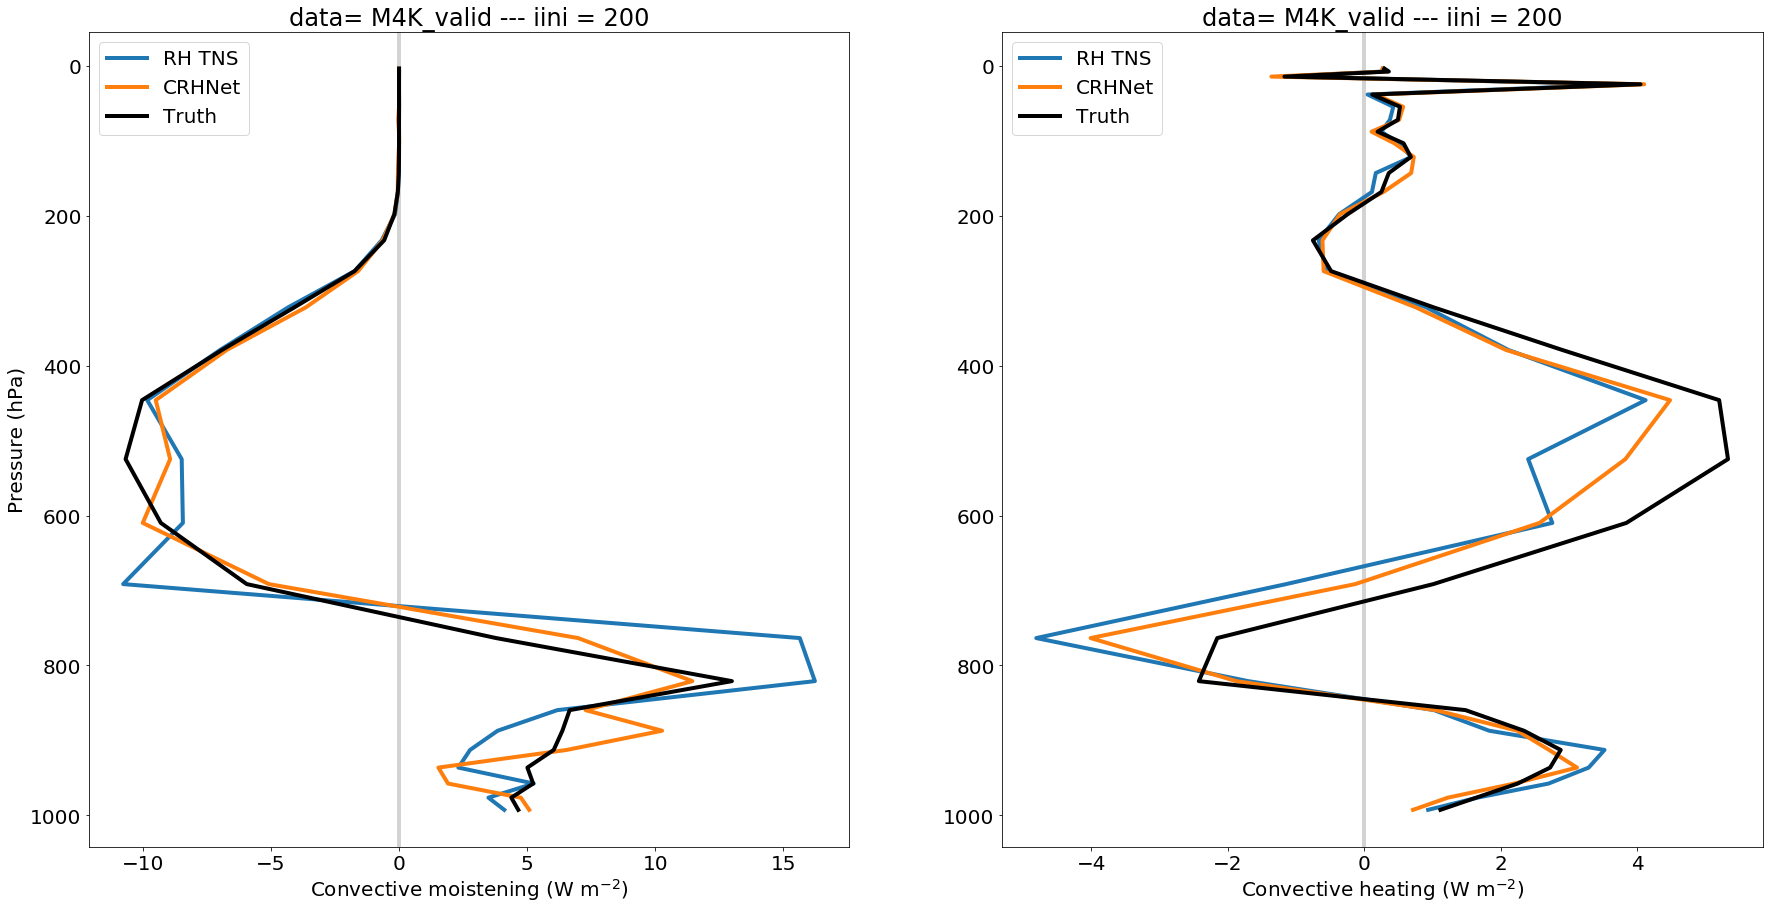

In [59]:


data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


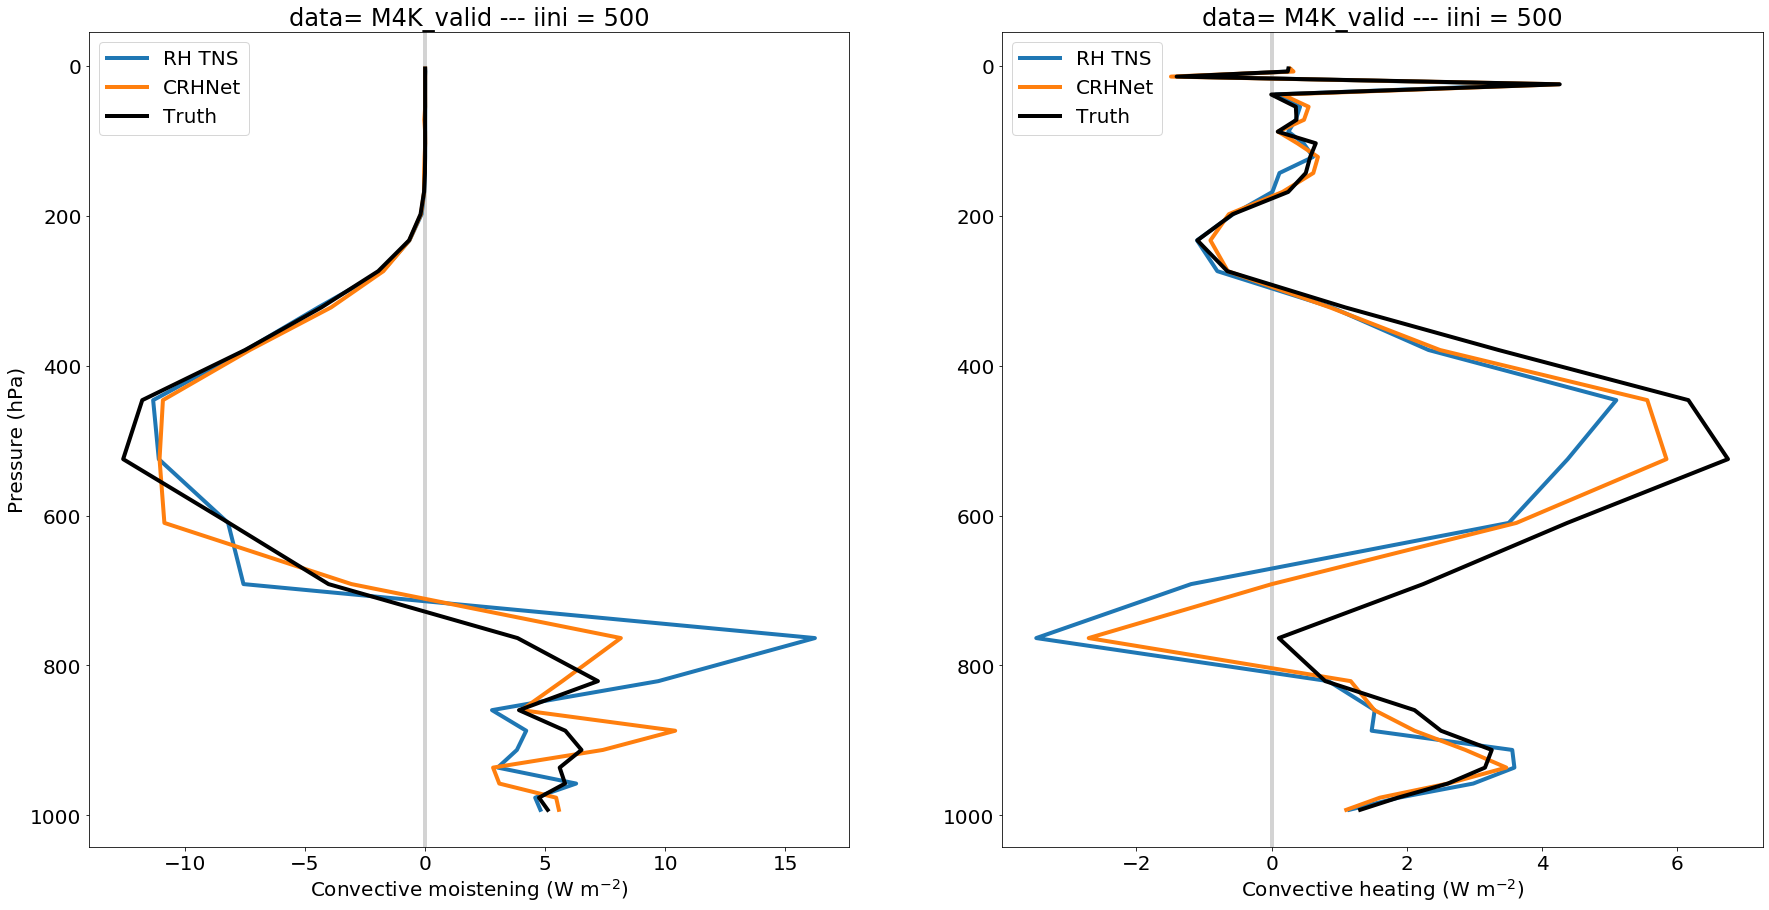

In [60]:


data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


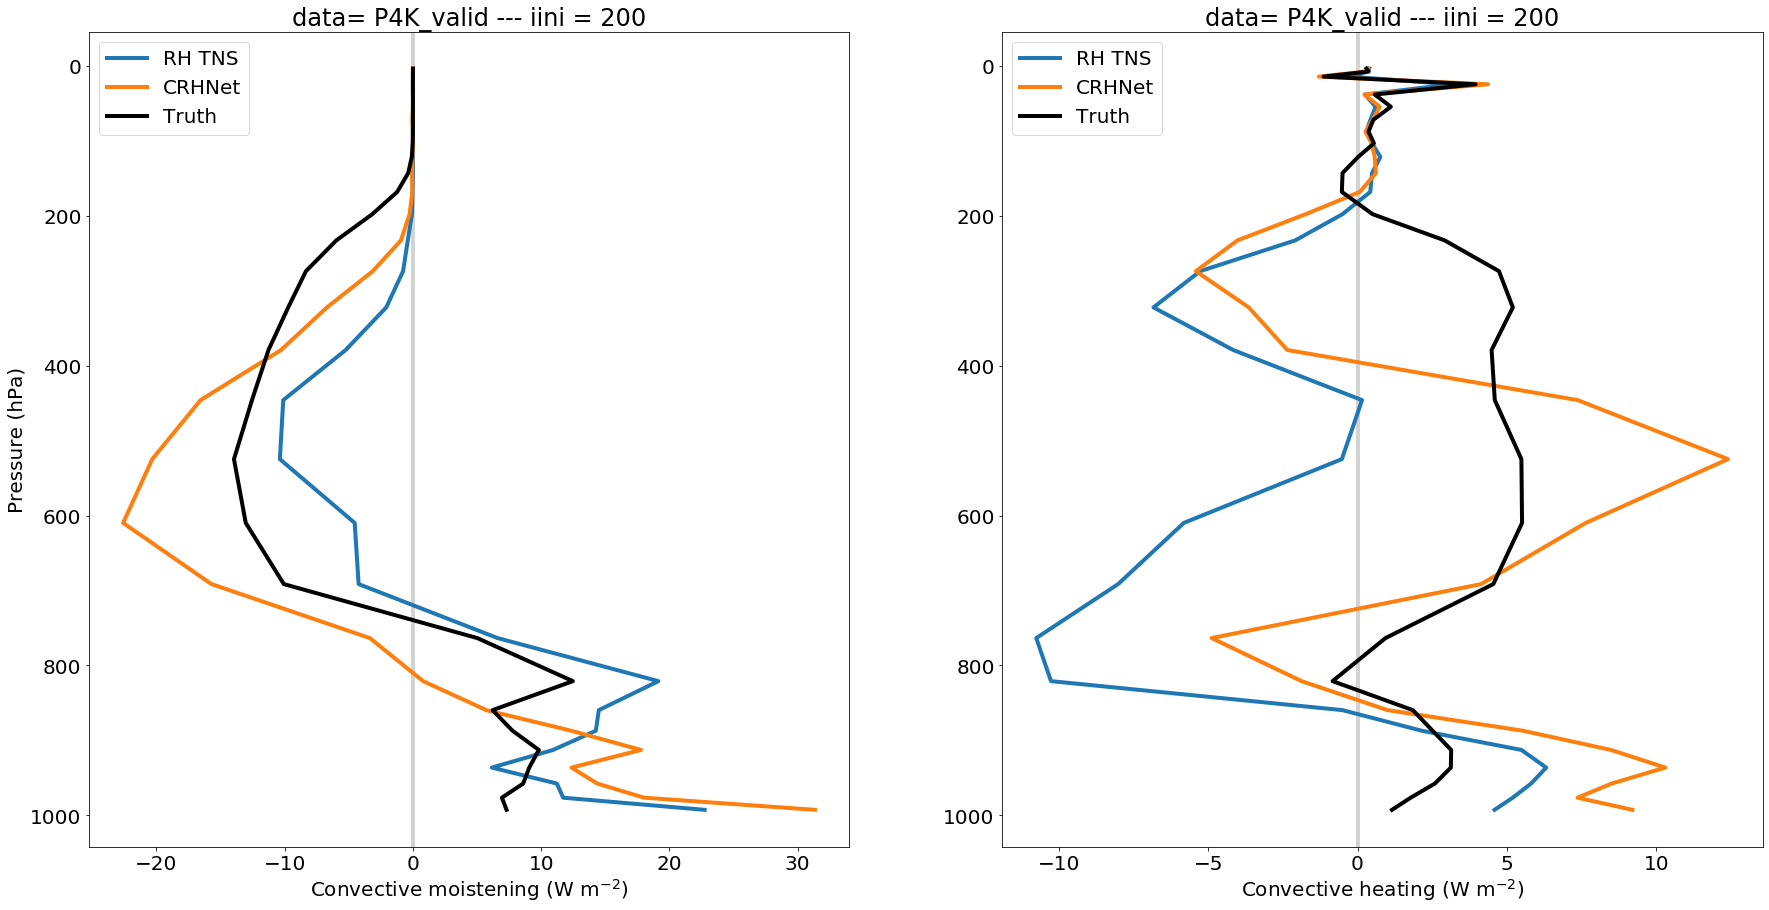

In [61]:


data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


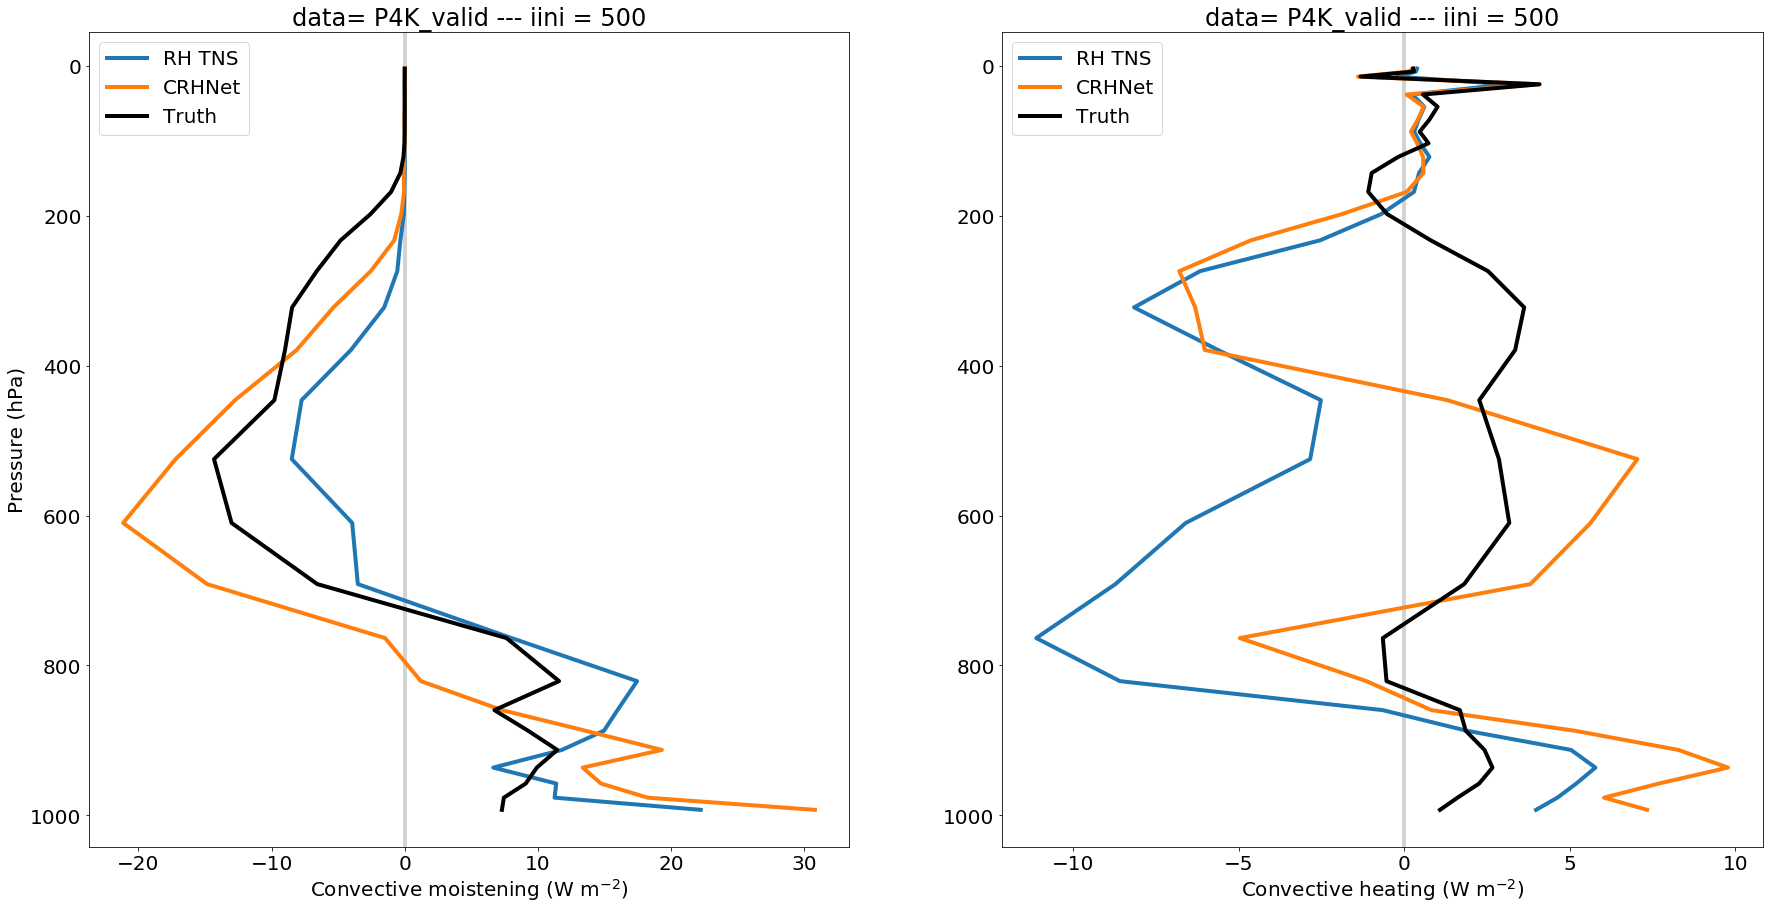

In [62]:


data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()


### Analysis for P4k Valid iini=500

In [63]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/CRHNet/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['CRHNet'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,'ScaleOp':ScaleOp}

In [64]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [67]:

NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    if '*' not in NNs:
        NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        if '*' in NNs:
            pos_path,neg_path = NNs.split('*')
            NN[NNs] = load_combined_model(path_HDF5+pos_path,path_HDF5+neg_path,dict_lay,
                                         '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                          '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData//HDF5_DATA'
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog
NN name is  Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [68]:
lat_ind = np.arange(26,40)
iinis = [500]
# iini = 414 # Initial time to sample
# iend = iini+47 # One day later
diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
diagno['truth_pos'] = {} # Diagnostics structure for the truth
diagno['truth_neg'] = {} # Diagnostics structure for the truth

for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: 
            diagno['truth'][data[6:-3]]={}
            diagno['truth_pos'][data[6:-3]]={}
            diagno['truth_neg'][data[6:-3]]={}
            
        
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: 
                diagno['truth'][data[6:-3]][iini] = {}
                diagno['truth_pos'][data[6:-3]][iini] = {}
                diagno['truth_neg'][data[6:-3]][iini] = {}
                
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                X, truth = md[NNs][data[6:-3]].valid_gen[itime]
                mask, pos_op, neg_op = md[NNs][data[6:-3]].model.predict_on_batch_seperate(X.values)
                
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                
                mask_reshaped = md[NNs][data[6:-3]].reshape_ngeo(mask)[lat_ind,:,:]
                mask = mask_reshaped.flatten()
                neg_mask = np.logical_not(mask)
#                 print(truth.shape)
#                 p = np.array(p)
#                 pos_truth = truth[mask]
#                 neg_truth = truth[np.logical_not(mask)]
#                 pos_op = np.array(pos_op)
#                 neg_op = np.array(neg_op)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth_pos'][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_pos'][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_neg'][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno['truth_neg'][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]

                        
                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                    diagno[NNs][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]

                    
                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        
#                         print(diagno[NNs][data[6:-3]][iini][field+'_pos'].shape)
#                         print(md[NNs][data[6:-3]].reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask][:,:,np.newaxis].shape)
                        
                        diagno[NNs][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_pos'],
                                     md[NNs][data[6:-3]].\
                                     reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                    axis=0)
                        
                        diagno[NNs][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_neg'],
                                     md[NNs][data[6:-3]].\
                                     reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                    axis=0)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)
                            diagno['truth_pos'][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno['truth_pos'][data[6:-3]][iini][field+'_pos'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                        axis=0)
                            diagno['truth_neg'][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno['truth_neg'][data[6:-3]][iini][field+'_neg'],
                                     md[NNs][data[6:-3]].\
                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                    axis=0)



i= 0 & NNs= Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5          


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:32: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


(14, 128, 30, 47)


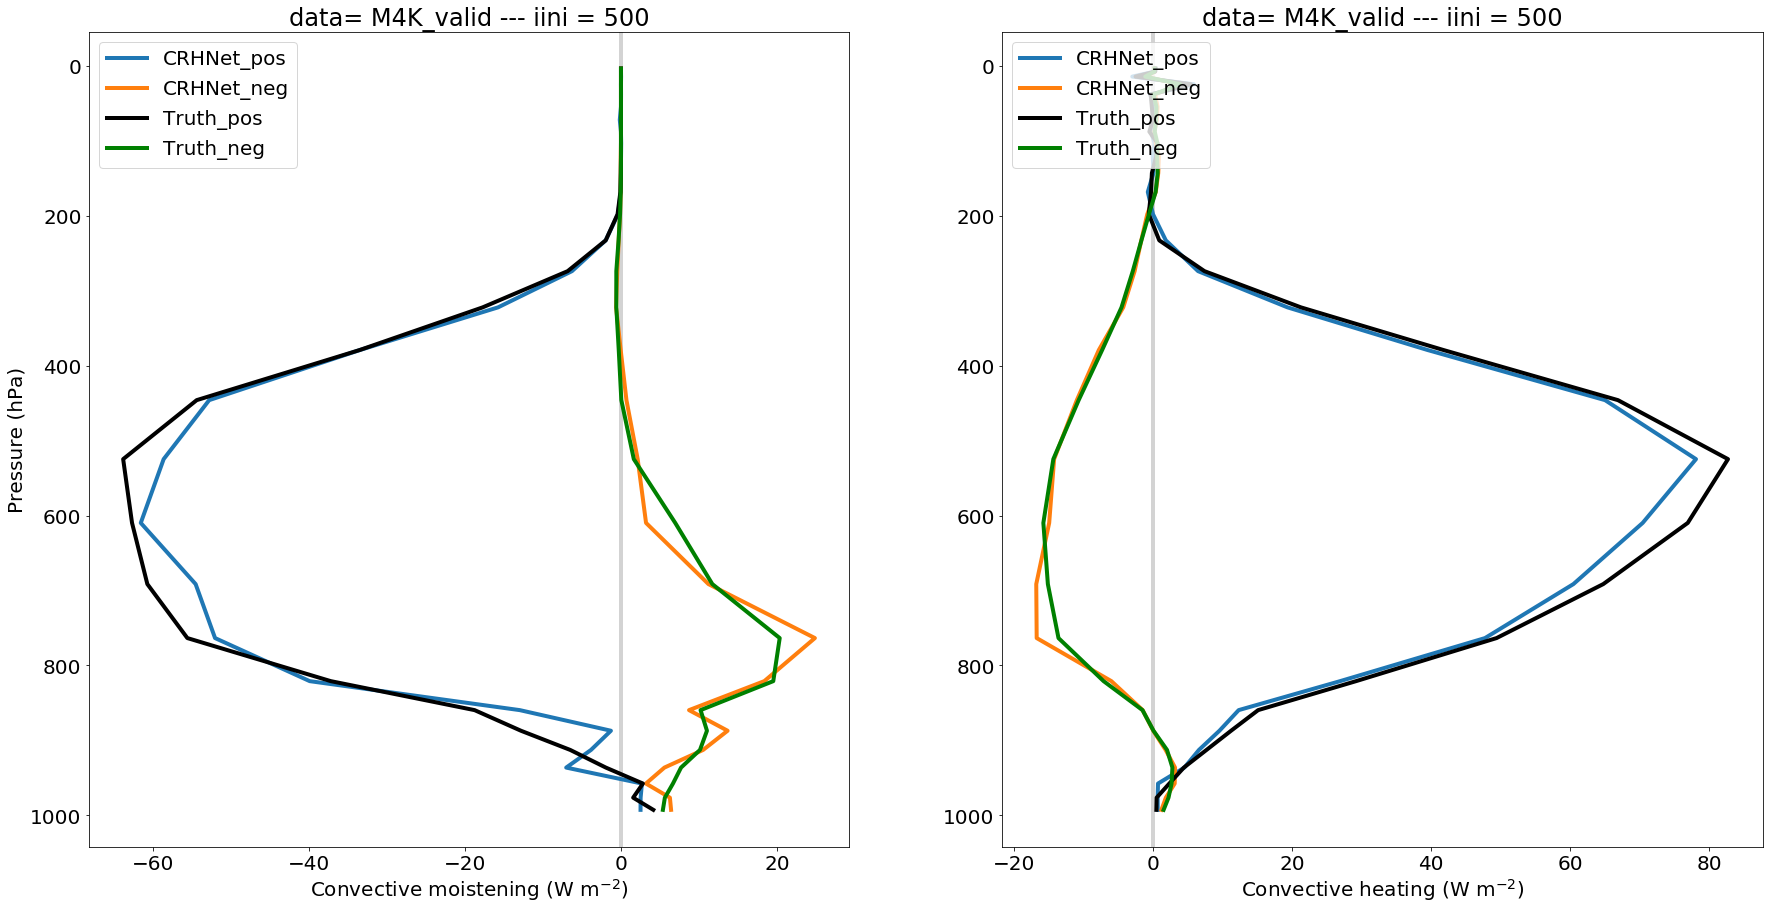

In [69]:
data = 'M4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[-1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_pos'],axis=0),lev,label='CRHNet_pos')
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='CRHNet_neg')
    
plt.plot(np.mean(diagno['truth_pos'][data][iini]['PHQ_pos'],axis=0),lev,label='Truth_pos',color='k')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth_neg',color='g')

plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


print(diagno[NNs][data][iini]['TPHYSTND'].shape)
plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_pos'],axis=0),lev,label='CRHNet_pos')
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_neg'],axis=0),lev,label='CRHNet_neg')
    
plt.plot(np.mean(diagno['truth_pos'][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Truth_pos',color='k')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth_neg',color='g')

plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()

(14, 128, 30, 47)


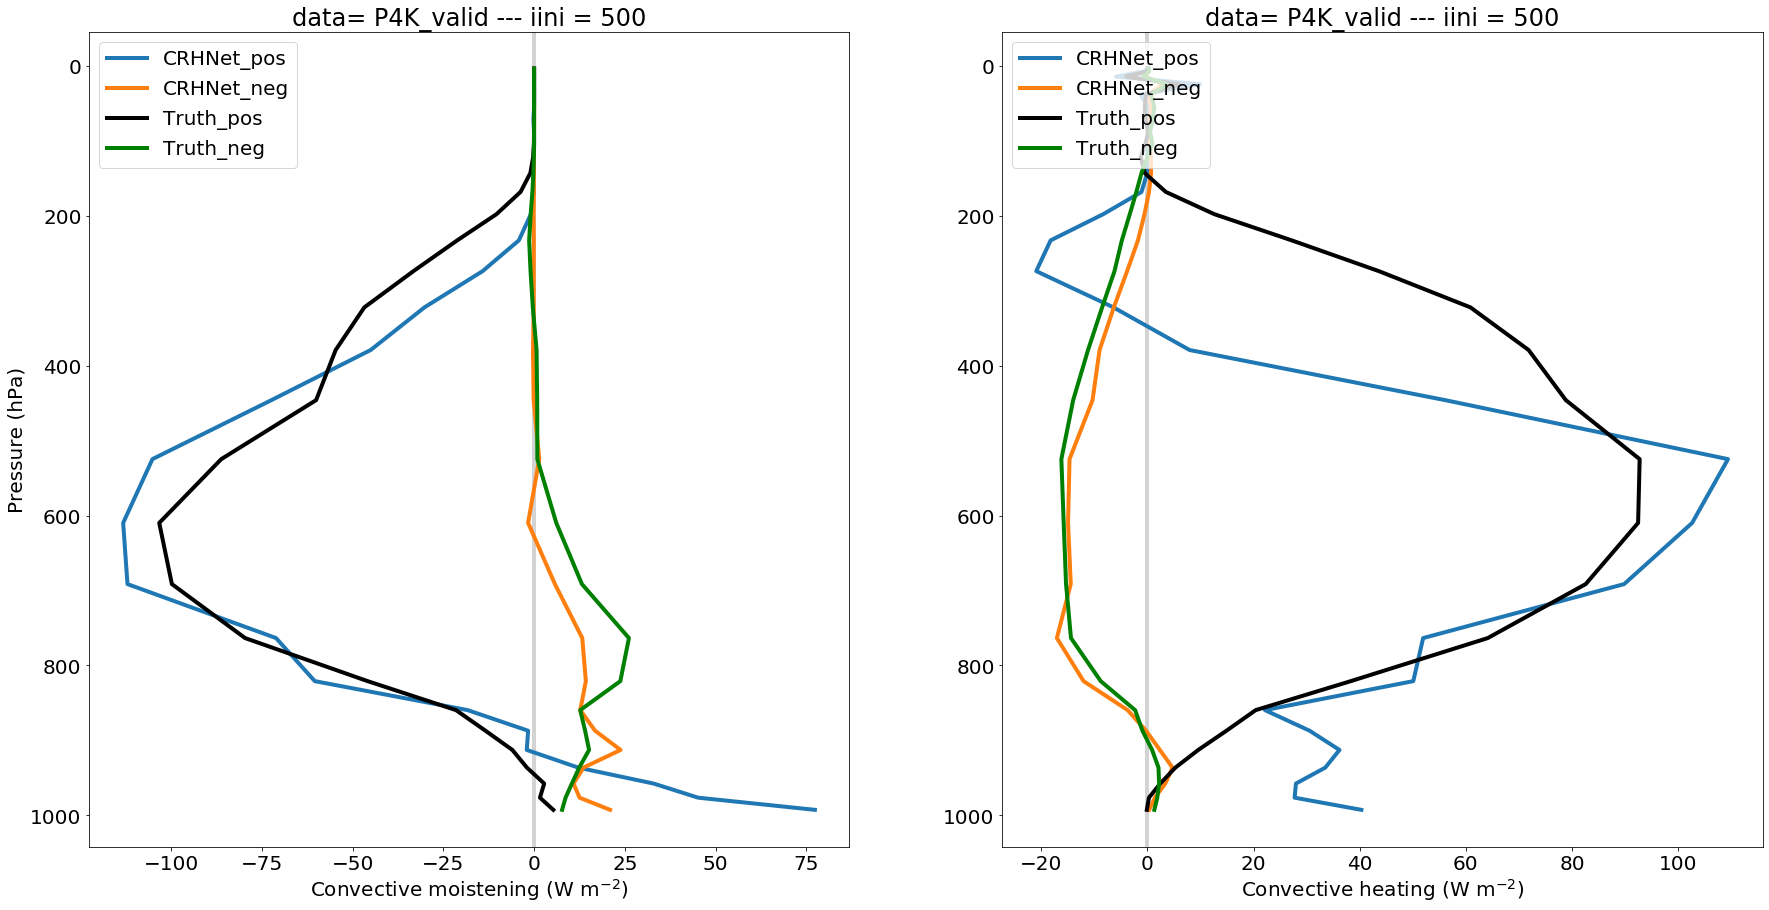

In [70]:
data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[-1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_pos'],axis=0),lev,label='CRHNet_pos')
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='CRHNet_neg')
    
plt.plot(np.mean(diagno['truth_pos'][data][iini]['PHQ_pos'],axis=0),lev,label='Truth_pos',color='k')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth_neg',color='g')

plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


print(diagno[NNs][data][iini]['TPHYSTND'].shape)
plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_pos'],axis=0),lev,label='CRHNet_pos')
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_neg'],axis=0),lev,label='CRHNet_neg')
    
plt.plot(np.mean(diagno['truth_pos'][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Truth_pos',color='k')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth_neg',color='g')

plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()

(14, 128, 30, 47)


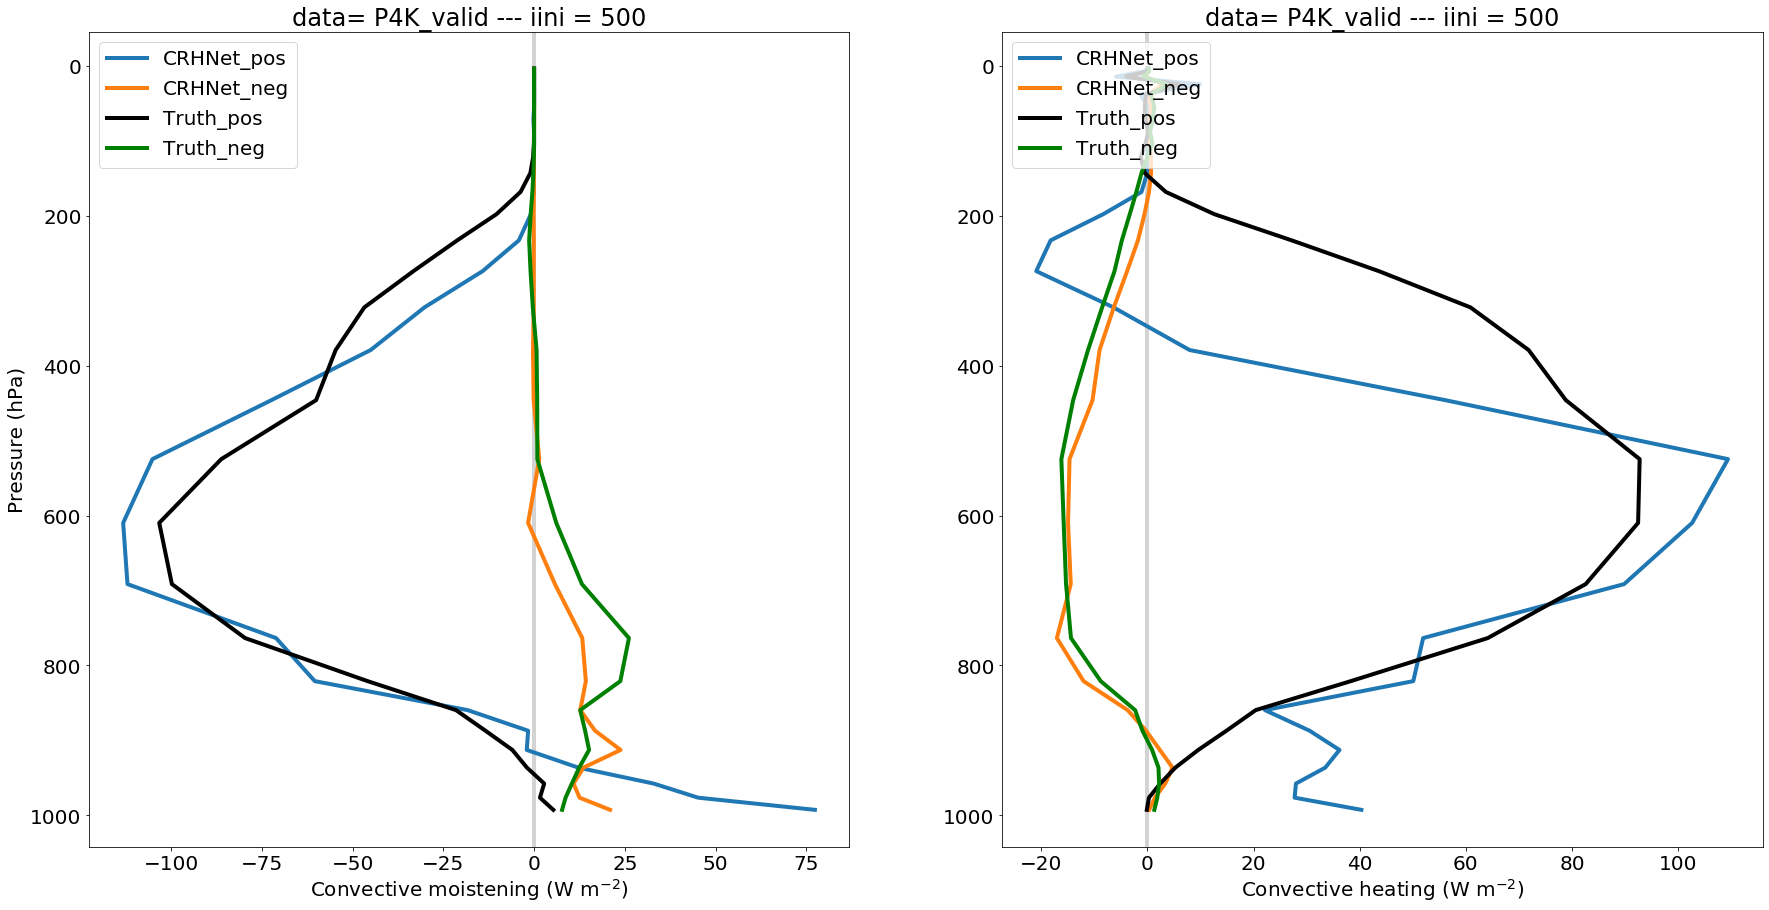

In [71]:
data = 'P4K_valid'
plt.figure(figsize=(30,15))
iini = iinis[-1]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_pos'],axis=0),lev,label='CRHNet_pos')
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='CRHNet_neg')
    
plt.plot(np.mean(diagno['truth_pos'][data][iini]['PHQ_pos'],axis=0),lev,label='Truth_pos',color='k')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth_neg',color='g')

plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
plt.title('data= '+data+' '+ '--- iini = '+str(iini))


print(diagno[NNs][data][iini]['TPHYSTND'].shape)
plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_pos'],axis=0),lev,label='CRHNet_pos')
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_neg'],axis=0),lev,label='CRHNet_neg')
    
plt.plot(np.mean(diagno['truth_pos'][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Truth_pos',color='k')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth_neg',color='g')

plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()

## Figures for Paper

### Figures 1, 2, 3 and 4

In [110]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_BF.hdf5'] # NN to evaluate
NNname = ['Brute Force'] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,'ScaleOp':ScaleOp}

In [111]:
# Indices of different variables
PHQ_idx = slice(0,30)
TPHYSTND_idx = slice(30,60)

In [112]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData//HDF5_DATA'
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog
NN name is  CI01_BF.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [113]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData//HDF5_DATA'
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog
NN name is  CI01_BF.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [115]:
# lat_ind = np.arange(26,40)
lat_ind = np.arange(0,7)
iinis = [500]
# iini = 414 # Initial time to sample
# iend = iini+47 # One day later
diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        if i==0: diagno['truth'][data[6:-3]]={}
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: diagno['truth'][data[6:-3]][iini] = {}
            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                p = np.array(p)
                # Get convective heating and moistening for each NN
                if itime==iini:
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]

                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)



i= 0 & NNs= CI01_BF.hdf5          


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [116]:
# Load coordinates (just pick any file from the climate model run)
coor = xr.open_dataset("/oasis/scratch/comet/ankitesh/temp_project/data/sp8fbp_minus4k.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon; lev = coor.lev;
coor.close();

In [117]:
fz = 20
lw = 4
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')


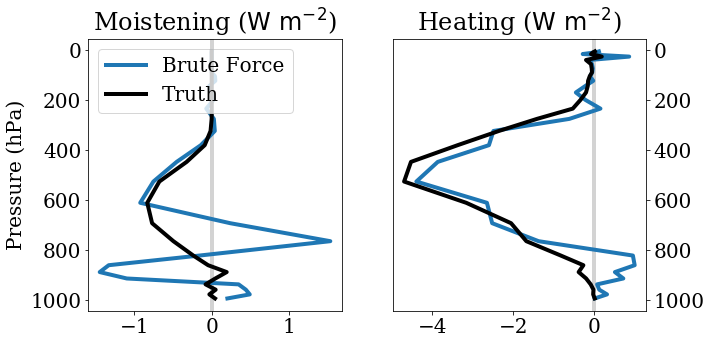

In [118]:
data = 'M4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()

# plt.tight_layout()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_m4k_truth_bf_2')

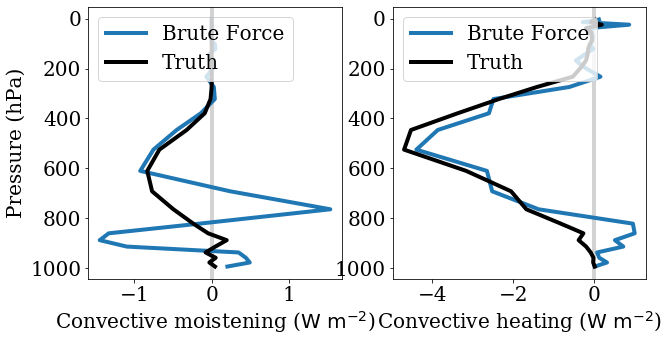

In [119]:
data = 'M4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.xlabel('Convective heating ($\mathrm{W\ m^{-2}}$)')
# plt.tight_layout()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_m4k_truth_bf_temp')

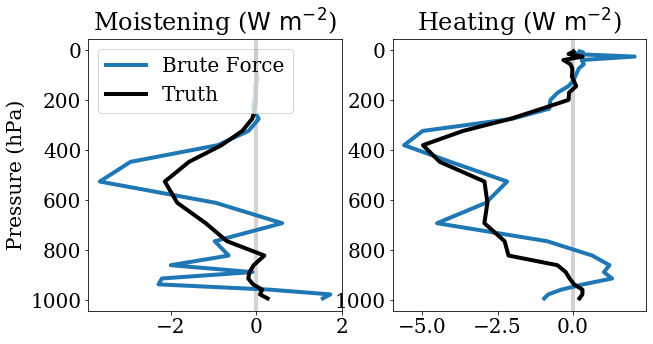

In [120]:
data = 'P4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_p4k_truth_bf_4')

### Figures 5,6,7,8,9,10,11,12,13

In [94]:
path_HDF5 = '/oasis/scratch/comet/ankitesh/temp_project/models/' # Path to NN weights
config_file = 'CI_SP_M4K_CONFIG.yml' # Configuration file
data_file = ['CI_SP_M4K_valid.nc','CI_SP_P4K_valid.nc'] # Validation/test data sets
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Relative humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer,
            'QV2RH':QV2RH,'T2TmTNS':T2TmTNS,'eliq':eliq,'eice':eice,'esat':esat,'qv':qv,'RH':RH,'ScaleOp':ScaleOp}

In [95]:
NN = {}; md = {};
%cd $TRAINDIR/HDF5_DATA
for i,NNs in enumerate(NNarray):
    print('NN name is ',NNs)
    path = path_HDF5+NNs
    if '*' not in NNs:
        NN[NNs] = load_model(path,custom_objects=dict_lay)
    md[NNs] = {}
    for j,data in enumerate(data_file):
        print('data name is ',data)
        if '*' in NNs:
            pos_path,neg_path = NNs.split('*')
            scaling = False
            if 'Scaled' in NNs:
                scaling = True
            NN[NNs] = load_combined_model(path_HDF5+pos_path,path_HDF5+neg_path,dict_lay,
                                         '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                          '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data,scaling=scaling)
            
        md[NNs][data[6:-3]] = ModelDiagnostics(NN[NNs],
                                                '/home/ankitesh/CBrain_project/PrepData/'+config_file,
                                                '/oasis/scratch/comet/ankitesh/temp_project/PrepData/'+data)

[Errno 2] No such file or directory: '/oasis/scratch/comet/ankitesh/temp_project/PrepData/CRHData//HDF5_DATA'
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog
NN name is  CI01_BF.hdf5
data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  CI01_RH.hdf5


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  CI01_RH_TNS.hdf5


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


data name is  CI_SP_M4K_valid.nc
data name is  CI_SP_P4K_valid.nc
NN name is  Pos_CRHNet.hdf5*Neg_CRHNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diag

data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


NN name is  Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5
data name is  CI_SP_M4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  This is separate from the ipykernel package so we can avoid doing imports until


data name is  CI_SP_P4K_valid.nc


/home/ankitesh/CBrain_project/CBRAIN-CAM/notebooks/ankitesh_devlog/cbrain/model_diagnostics.py:30: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(f)


In [96]:
# lat_ind = np.arange(26,40)
lat_ind = np.arange(0,7)

iinis = [500]
# iini = 414 # Initial time to sample
# iend = iini+47 # One day later
diagno = {} # Diagnostics structure
diagno['truth'] = {} # Diagnostics structure for the truth
diagno['truth_pos'] = {} # Diagnostics structure for the truth
diagno['truth_neg'] = {} # Diagnostics structure for the truth

for i,NNs in enumerate(NNarray):
    print('i=',i,'& NNs=',NNs,'         ')
    diagno[NNs] = {} # Diagnostics structure for each NN
    for j,data in enumerate(data_file):
        diagno[NNs][data[6:-3]]={}
        
        if i==0: 
            diagno['truth'][data[6:-3]]={}
            diagno['truth_pos'][data[6:-3]]={}
            diagno['truth_neg'][data[6:-3]]={}
            
        
        for iini in iinis:
            
            print('j=',j,'& iini=',iini,'& data=',data,'         ',end='\r'),
            
            iend = iini+47
            diagno[NNs][data[6:-3]][iini] = {} # Diagnostics structure for each data file
            if i==0: 
                diagno['truth'][data[6:-3]][iini] = {}
                diagno['truth_pos'][data[6:-3]][iini] = {}
                diagno['truth_neg'][data[6:-3]][iini] = {}

            for itime in tqdm(np.arange(iini,iend)):
                # Get input, prediction and truth from NN
                X, truth = md[NNs][data[6:-3]].valid_gen[itime]
                
                if '*' in NNs:
                    mask, pos_op, neg_op = md[NNs][data[6:-3]].model.predict_on_batch_seperate(X.values)
                        
                    mask_reshaped = md[NNs][data[6:-3]].reshape_ngeo(mask)[lat_ind,:,:]
                    mask = mask_reshaped.flatten()
                    neg_mask = np.logical_not(mask)
                    
                
                inp, p, truth = md[NNs][data[6:-3]].get_inp_pred_truth(itime)  # [lat, lon, var, lev]
                p = np.array(p)
                


                # Get convective heating and moistening for each NN
                if itime==iini:
                    
                    if i==0:
                        diagno['truth'][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                        diagno['truth'][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
 
                        mask, pos_op, neg_op = md['Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'][data[6:-3]].model.predict_on_batch_seperate(X.values)
                        mask_reshaped = md['Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'][data[6:-3]].reshape_ngeo(mask)[lat_ind,:,:]
                        mask = mask_reshaped.flatten()
                        neg_mask = np.logical_not(mask)
                        diagno['truth_pos'][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_pos'][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno['truth_neg'][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno['truth_neg'][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(truth[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]


                    diagno[NNs][data[6:-3]][iini]['PHQ'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:,np.newaxis]
                    diagno[NNs][data[6:-3]][iini]['TPHYSTND'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:,np.newaxis]
                    if '*' in NNs:
                        diagno[NNs][data[6:-3]][iini]['PHQ_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_pos'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[mask]
                        diagno[NNs][data[6:-3]][iini]['PHQ_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,PHQ_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]
                        diagno[NNs][data[6:-3]][iini]['TPHYSTND_neg'] = md[NNs][data[6:-3]].reshape_ngeo(p[:,TPHYSTND_idx])[lat_ind,:,:].reshape(-1,30)[neg_mask]


                else:
                    for istr,field in enumerate(['PHQ','TPHYSTND']):
                        if field=='PHQ': ind_field = PHQ_idx
                        elif field=='TPHYSTND': ind_field = TPHYSTND_idx
                        diagno[NNs][data[6:-3]][iini][field] = np.concatenate((diagno[NNs][data[6:-3]][iini][field],
                                                             md[NNs][data[6:-3]].\
                                                             reshape_ngeo(p[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                            axis=3)
                        
#                         print(diagno[NNs][data[6:-3]][iini][field+'_pos'].shape)
#                         print(md[NNs][data[6:-3]].reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask][:,:,np.newaxis].shape)
                        if '*' in NNs:
                            diagno[NNs][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_pos'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                        axis=0)

                            diagno[NNs][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno[NNs][data[6:-3]][iini][field+'_neg'],
                                         md[NNs][data[6:-3]].\
                                         reshape_ngeo(p[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                        axis=0)
                        if i==0:
                            diagno['truth'][data[6:-3]][iini][field] = np.concatenate((diagno['truth'][data[6:-3]][iini][field],
                                                                     md[NNs][data[6:-3]].\
                                                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:,np.newaxis]),
                                                                    axis=3)
                            mask, pos_op, neg_op = md['Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'][data[6:-3]].model.predict_on_batch_seperate(X.values)
                            mask_reshaped = md['Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'][data[6:-3]].reshape_ngeo(mask)[lat_ind,:,:]
                            mask = mask_reshaped.flatten()
                            neg_mask = np.logical_not(mask)
                            diagno['truth_pos'][data[6:-3]][iini][field+'_pos'] = np.concatenate((diagno['truth_pos'][data[6:-3]][iini][field+'_pos'],
                                         md[NNs][data[6:-3]].\
                                             reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[mask]),
                                            axis=0)
                            diagno['truth_neg'][data[6:-3]][iini][field+'_neg'] = np.concatenate((diagno['truth_neg'][data[6:-3]][iini][field+'_neg'],
                                     md[NNs][data[6:-3]].\
                                     reshape_ngeo(truth[:,ind_field])[lat_ind,:,:].reshape(-1,30)[neg_mask]),
                                    axis=0)



i= 0 & NNs= CI01_BF.hdf5          


/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



i= 1 & NNs= CI01_RH.hdf5          



i= 2 & NNs= CI01_RH_TNS.hdf5          



i= 3 & NNs= Pos_CRHNet.hdf5*Neg_CRHNet.hdf5          



i= 4 & NNs= Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5          


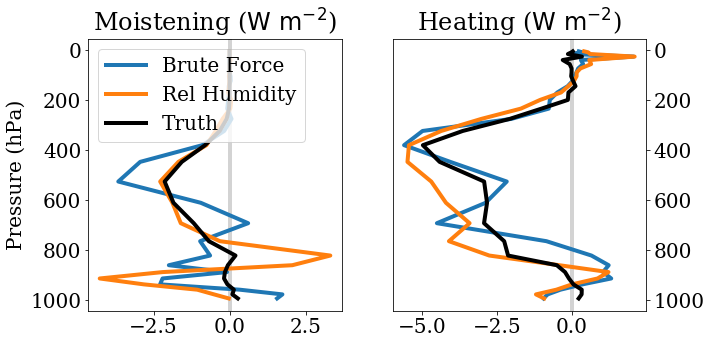

In [98]:
data = 'P4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Rel Humidity','T minus surf.T',"CRH Split", "PW Scaled"]
for iNN,NNs in enumerate(NNarray[:2]):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[:2]):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_p4k_truth_bf_RH_5')

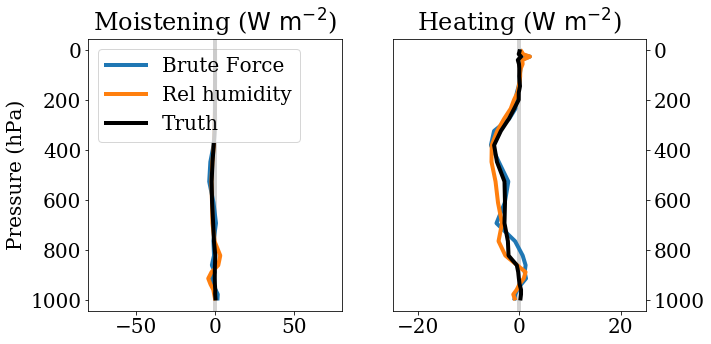

In [99]:
data = 'P4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Rel humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
plt.axvline(x=0,c='lightgray')
plt.xlim(-80,80)
for iNN,NNs in enumerate(NNarray[:2]):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-25,25)

plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[:2]):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_p4k_truth_bf_RH_zoomed_6')

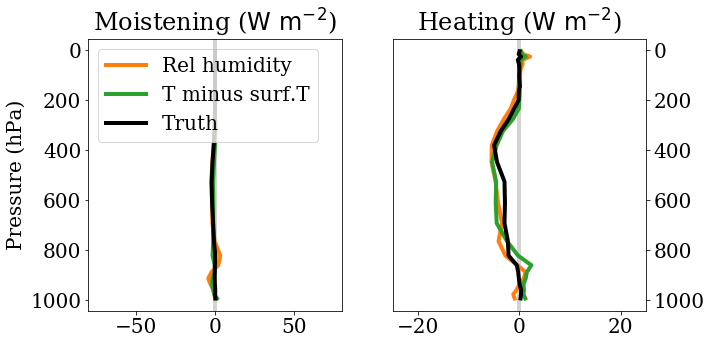

In [100]:
data = 'P4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Rel humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
NNname = NNname[1:3]
colors = ['C1','C2']
plt.xlim(-80,80)
for iNN,NNs in enumerate(NNarray[1:3]):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-25,25)

plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray[1:3]):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_p4k_truth_RH_RHTNS_7')

In [101]:
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_pos'],axis=0),lev,label='CRHNet_pos')
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='CRHNet_neg')
    
plt.plot(np.mean(diagno['truth_pos'][data][iini]['PHQ_pos'],axis=0),lev,label='Truth_pos',color='k')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth_neg',color='g')

KeyError: 'PHQ_pos'

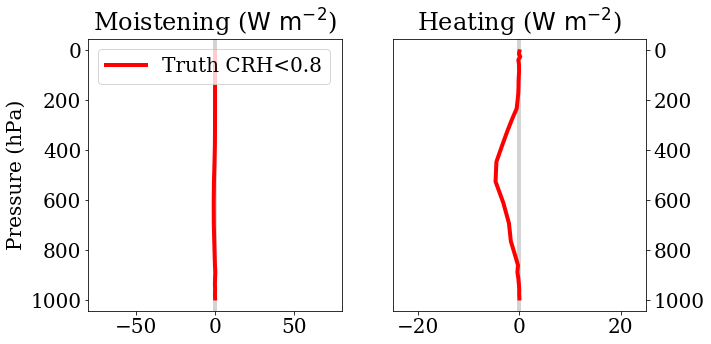

In [102]:
data = 'M4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Rel humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
NNarray = NNarray[3]
NNname = NNname[3]

# colors = ['orange','green']
plt.xlim(-80,80)
# for iNN,NNs in enumerate(NNarray):
#      plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='CRHNet_neg', color='red')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth CRH<0.8',color='red')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-25,25)
plt.axvline(x=0,c='lightgray')
# for iNN,NNs in enumerate(NNarray):
#      plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='CRHNet_neg', color='red')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth CRH<0.8',color='red')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_m4k_crhnet_TruthNeg_8*1')

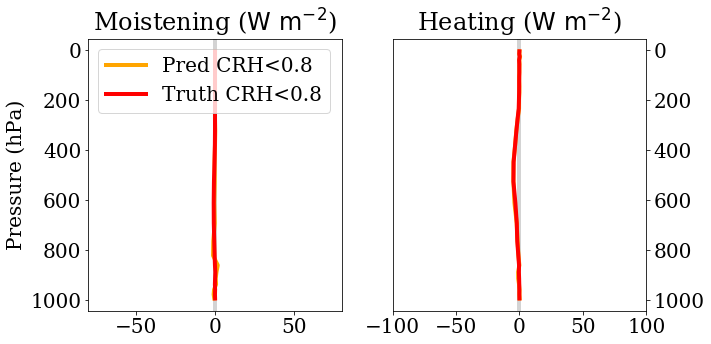

In [103]:
data = 'M4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Rel humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
NNarray = [NNarray[3]]
NNname = [NNname[3]]

# colors = ['orange','green']
plt.xlim(-80,80)
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='Pred CRH<0.8', color='orange')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth CRH<0.8',color='red')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-100,100)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
     plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Pred for CRH<0.8', color='orange')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth for CRH<0.8',color='red')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_m4k_crhnet_TruthPredNeg_8*2')

/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ankitesh/miniconda3/envs/CbrainCustomLayer/lib/python3.6/si

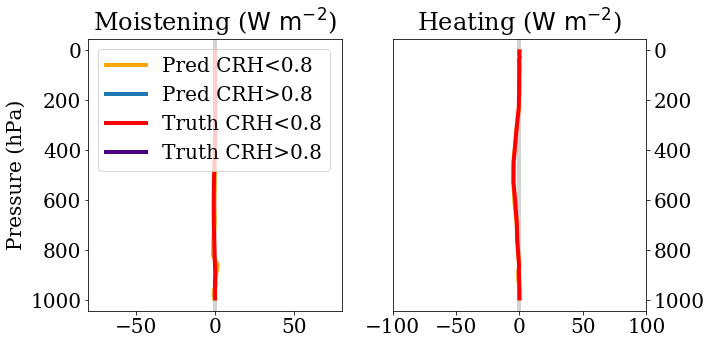

In [104]:
data = 'M4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Rel humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
NNarray = [NNarray[3]]
NNname = [NNname[3]]

# colors = ['orange','green']
plt.xlim(-80,80)
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='Pred CRH<0.8', color='orange')
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_pos'],axis=0),lev,label='Pred CRH>0.8', color='C0')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth CRH<0.8',color='red')
plt.plot(np.mean(diagno['truth_pos'][data][iini]['PHQ_pos'],axis=0),lev,label='Truth CRH>0.8',color='indigo')

plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-100,100)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Pred for CRH<0.8', color='orange')
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Pred for CRH>0.8', color='C0')
        
plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth for CRH<0.8',color='red')
plt.plot(np.mean(diagno['truth_pos'][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Truth for CRH>0.8',color='indigo')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_m4k_crhnet_TruthPredNeg_TruthPredPos_8*4')

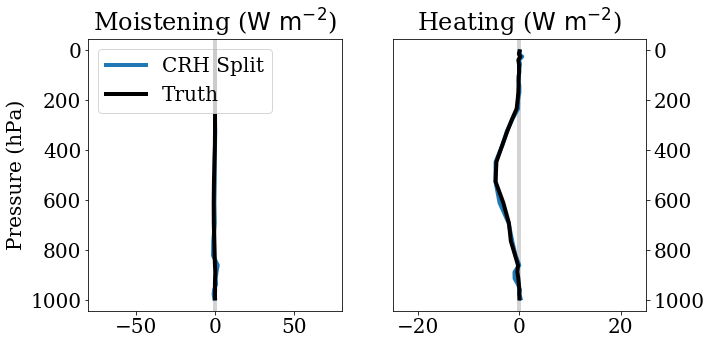

In [105]:
data = 'M4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Relative humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
NNarray = [NNarray[3]]
NNname = [NNname[3]]
plt.xlim(-80,80)
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-25,25)

plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_m4k_truth_CRHSplit_9')

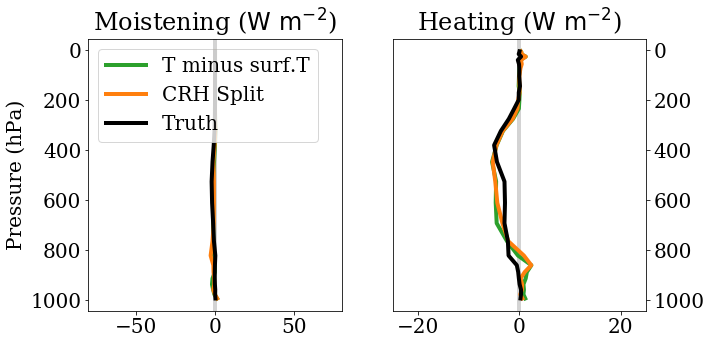

In [106]:
data = 'P4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Relative humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
NNarray = [NNarray[2],NNarray[3]]
NNname = [NNname[2],NNname[3]]
plt.xlim(-80,80)
colors = ['C2','C1']
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-25,25)

plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_p4k_truth_CRHSplit_RHTNS_10')

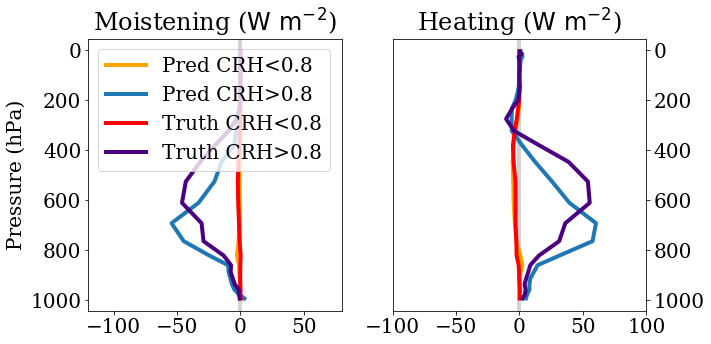

In [107]:
data = 'P4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Relative humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
NNarray = [NNarray[3]]
NNname = [NNname[3]]

# colors = ['orange','green']
plt.xlim(-120,80)
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='Pred CRH<0.8', color='orange')
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_pos'],axis=0),lev,label='Pred CRH>0.8', color='C0')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth CRH<0.8',color='red')
plt.plot(np.mean(diagno['truth_pos'][data][iini]['PHQ_pos'],axis=0),lev,label='Truth CRH>0.8',color='indigo')

plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-100,100)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Pred for CRH<0.8', color='orange')
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Pred for CRH>0.8', color='C0')
        
plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth for CRH<0.8',color='red')
plt.plot(np.mean(diagno['truth_pos'][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Truth for CRH>0.8',color='indigo')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_p4k_crhnet_TruthPredNeg_TruthPredPos_11')

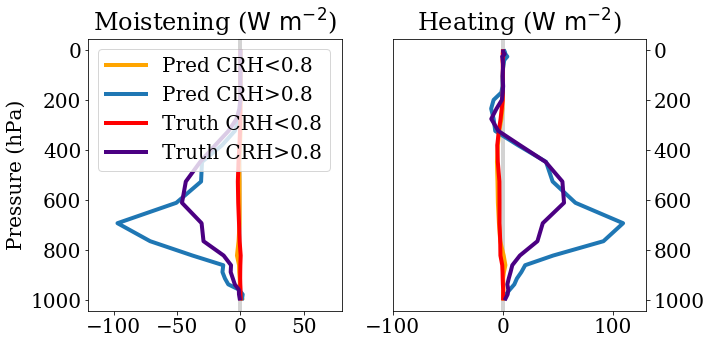

In [108]:
data = 'P4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Relative humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
NNarray = [NNarray[4]]
NNname = [NNname[4]]

# colors = ['orange','green']
plt.xlim(-120,80)
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_neg'],axis=0),lev,label='Pred CRH<0.8', color='orange')
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ_pos'],axis=0),lev,label='Pred CRH>0.8', color='C0')
plt.plot(np.mean(diagno['truth_neg'][data][iini]['PHQ_neg'],axis=0),lev,label='Truth CRH<0.8',color='red')
plt.plot(np.mean(diagno['truth_pos'][data][iini]['PHQ_pos'],axis=0),lev,label='Truth CRH>0.8',color='indigo')

plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-100,130)
plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Pred for CRH<0.8', color='orange')
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Pred for CRH>0.8', color='C0')
        
plt.plot(np.mean(diagno['truth_neg'][data][iini]['TPHYSTND_neg'],axis=0),lev,label='Truth for CRH<0.8',color='red')
plt.plot(np.mean(diagno['truth_pos'][data][iini]['TPHYSTND_pos'],axis=0),lev,label='Truth for CRH>0.8',color='indigo')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_p4k_crhScalednet_TruthPredNeg_TruthPredPos_12')

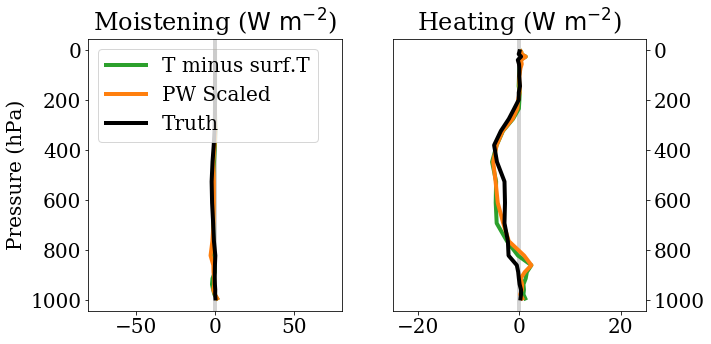

In [109]:
data = 'P4K_valid'
plt.figure(figsize=(10,5))
iini = iinis[0]
plt.subplot(1,2,1)
plt.axvline(x=0,c='lightgray')
NNarray = ['CI01_BF.hdf5','CI01_RH.hdf5','CI01_RH_TNS.hdf5','Pos_CRHNet.hdf5*Neg_CRHNet.hdf5','Pos_CRH_Scaled_CRHNet.hdf5*Neg_CRHNet.hdf5'] # NN to evaluate
NNname = ['Brute Force', 'Relative humidity','T minus surf.T',"CRH Split", "PW Scaled"] # Name of NNs for plotting
NNarray = [NNarray[2],NNarray[4]]
NNname = [NNname[2],NNname[4]]
plt.xlim(-80,80)
colors = ['C2','C1']
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['PHQ'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['PHQ'],axis=(0,1,3)),lev,label='Truth',color='k')
plt.legend(loc="upper left")
plt.title('Moistening ($\mathrm{W\ m^{-2}}$)')
plt.ylabel('Pressure (hPa)')
plt.gca().invert_yaxis()
# plt.title('data='+data+' '+ '--- iini = '+str(iini))

ax = plt.subplot(1,2,2)
plt.xlim(-25,25)

plt.axvline(x=0,c='lightgray')
for iNN,NNs in enumerate(NNarray):
    plt.plot(np.mean(diagno[NNs][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label=NNname[iNN],color=colors[iNN])
plt.plot(np.mean(diagno['truth'][data][iini]['TPHYSTND'],axis=(0,1,3)),lev,label='Truth',color='k')
# plt.legend(loc="upper left")
plt.title('Heating ($\mathrm{W\ m^{-2}}$)')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
# plt.title('data= '+data+' '+ '--- iini = '+str(iini))
plt.gca().invert_yaxis()
plt.savefig('figures/data_p4k_truth_CRHScaledSplit_RHTNS_13')